In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import operator

from collections import defaultdict

from PIL import Image, ImageDraw, ImageFont

from skimage import transform as tf
from skimage.measure import label, regionprops
from skimage.transform import resize

from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

# ! Special installation required.
# Clone the repo at https://github.com/pybrain/pybrain, then run 'python3 setup.py install'.
# vim /usr/local/lib/python3.7/site-packages/pybrain/tools/functions.py
# Change this line:
# from: from scipy.linalg import inv, det, svd, logm, expm2 to 
# to  : from scipy.linalg import inv, det, svd, logm, expm
from pybrain.datasets import SupervisedDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer

from nltk import edit_distance
from nltk.corpus import words

In [2]:
def create_captcha(text, shear=0, size=(100, 24)):
    im = Image.new('L', size, 'black')
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r'Coval-Regular.otf', 22)
    draw.text((2, 2), text, fill=1, font=font)
    
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear, 
                                   translation=(0, 5)) # This is to fix the hidden image.
    image = tf.warp(image, affine_tf)
    return image / image.max()

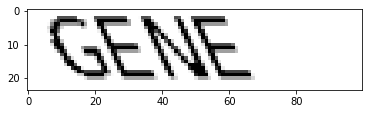

In [3]:
image = create_captcha('GENE', shear=0.5)
plt.imshow(image, cmap='Greys')

In [4]:
def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    
    if len(subimages) == 0:
        return [image,]
    return subimages

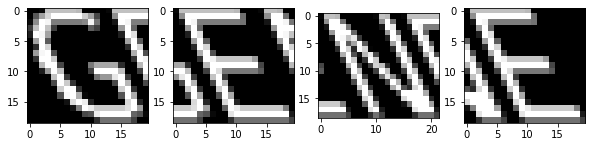

In [5]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))

for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap='gray')

In [6]:
random_state = check_random_state(14)
letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
shear_values = np.arange(0, 0.5, 0.05)

In [7]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)

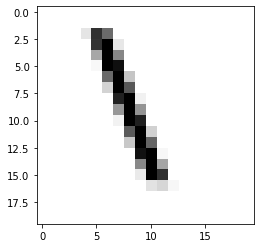

In [8]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap='Greys')

In [9]:
f'The target for this image is {letters[target]}'

'The target for this image is L'

In [10]:
dataset, targets = zip(*(generate_sample(random_state) 
                         for i in range(3000)))
dataset = np.array(dataset, dtype=np.float64)
targets = np.array(targets)

In [11]:
onehot = OneHotEncoder(categories='auto')
y = onehot.fit_transform(targets.reshape(-1, 1))
y = y.todense()
y[0]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) 
                    for sample in dataset])

In [13]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
dataset.shape, X.shape

((3000, 20, 20), (3000, 400))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

## Training and Classifying

In [15]:
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])

In [16]:
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

In [17]:
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

In [18]:
trainer = BackpropTrainer(net, 
                          training, 
                          learningrate=0.01,
                          weightdecay=0.01)

In [19]:
trainer.trainEpochs(epochs=20)

In [20]:
predictions = trainer.testOnClassData(dataset=testing, verbose=True)

In [21]:
f'F-score: {f1_score(predictions, y_test.argmax(axis=1), average="micro"):.2f}'

'F-score: 0.84'

In [22]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ''
    
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

'MMMA'

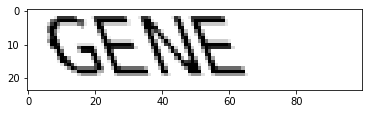

In [23]:
word = 'GENE'
captcha = create_captcha(word, shear=0.4)
plt.imshow(captcha, cmap='Greys')
predict_captcha(captcha, net)

In [24]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [25]:
valid_words = [word.upper() 
               for word in words.words() 
               if len(word) == 4]
len(valid_words)

5513

In [26]:
num_correct = 0
num_incorrect = 0

for word in valid_words:
    correct, word, prediction = test_prediction(word, 
                                                net, 
                                                shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1

In [27]:
num_correct, num_incorrect

(48, 5465)

In [28]:
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

Text(0.5, 0, 'Predicted')

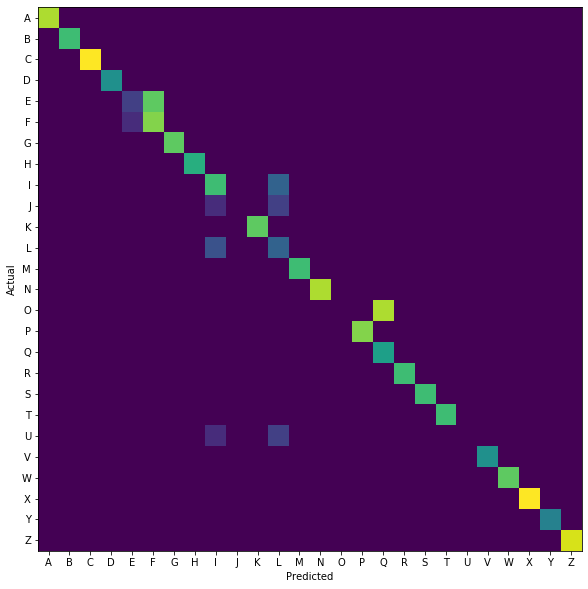

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(cm)
tick_marks = np.arange(len(letters))
plt.xticks(tick_marks, letters)
plt.yticks(tick_marks, letters)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [30]:
## Improving accuracy using dictionary.

In [31]:
steps = edit_distance('STEP', 'STOP')
f'The number of steps needed is {steps}'

'The number of steps needed is 1'

In [32]:
def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == word[i] 
                                 for i in range(len(prediction)))

In [33]:
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word))
                            for word in dictionary], 
                           key=operator.itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [34]:
result = defaultdict(int)
for word in valid_words:
    correct, word, predictions = improved_prediction(word,
                                                     net, 
                                                     valid_words,
                                                     shear=0.2)
    result[correct] += 1

In [35]:
result

defaultdict(int, {False: 5350, True: 163})